In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist


2026-01-29 05:41:29.415254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769665289.632286      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769665289.696500      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769665290.178420      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769665290.178457      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769665290.178460      55 computation_placer.cc:177] computation placer alr

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize to range [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten images (28x28 → 784)
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 784)
Testing data shape: (10000, 784)


In [3]:
input_dim = 784
hidden_dim = 256
latent_dim = 2


In [4]:
inputs = layers.Input(shape=(input_dim,))
h = layers.Dense(hidden_dim, activation="relu")(inputs)

z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)


I0000 00:00:1769665334.230201      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769665334.234098      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


In [6]:
latent_inputs = layers.Input(shape=(latent_dim,))
h_dec = layers.Dense(hidden_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(input_dim, activation="sigmoid")(h_dec)

decoder = Model(latent_inputs, outputs, name="decoder")


In [15]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * input_dim

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss
        }


In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")


In [17]:
history = vae.fit(
    x_train,
    epochs=30,
    batch_size=128
)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - kl_loss: 3.1610 - loss: 160.8985 - reconstruction_loss: 157.7376
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.2317 - loss: 159.1328 - reconstruction_loss: 155.9010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.2843 - loss: 157.6502 - reconstruction_loss: 154.3659
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.3612 - loss: 156.2575 - reconstruction_loss: 152.8963
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.4126 - loss: 155.0795 - reconstruction_loss: 151.6670
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.4522 - loss: 154.1140 - reconstruction_loss: 150.6617
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.4782 - loss: 153.2062 - reconstruction_loss: 149.7280
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 3.5054 - loss: 152.4942 - reconstruction_loss: 148.9887
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

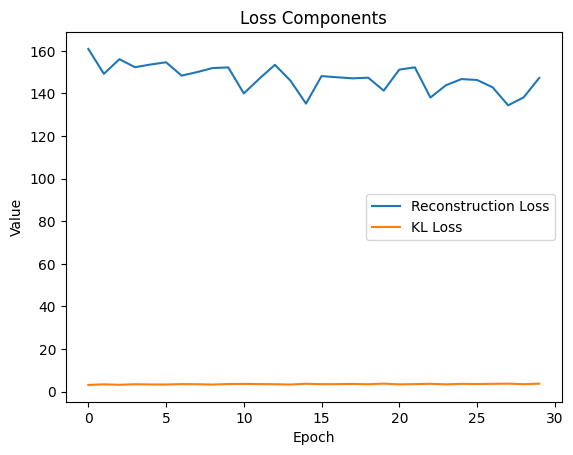

In [19]:
plt.plot(history.history["reconstruction_loss"])
plt.plot(history.history["kl_loss"])
plt.legend(["Reconstruction Loss", "KL Loss"])
plt.title("Loss Components")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


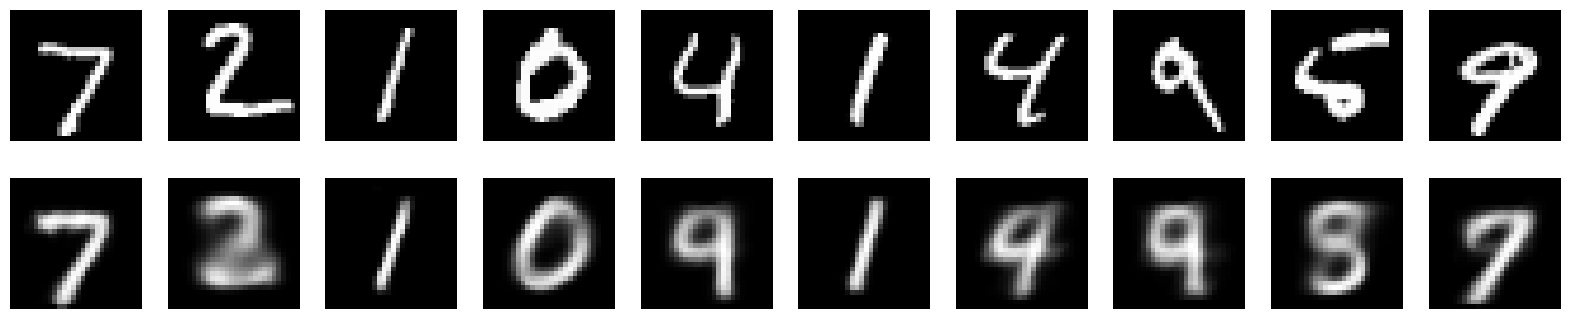

In [20]:
n = 10
test_images = x_test[:n]
reconstructed = vae.predict(test_images)

plt.figure(figsize=(20,4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, n, i+n+1)
    plt.imshow(reconstructed[i].reshape(28,28), cmap="gray")
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


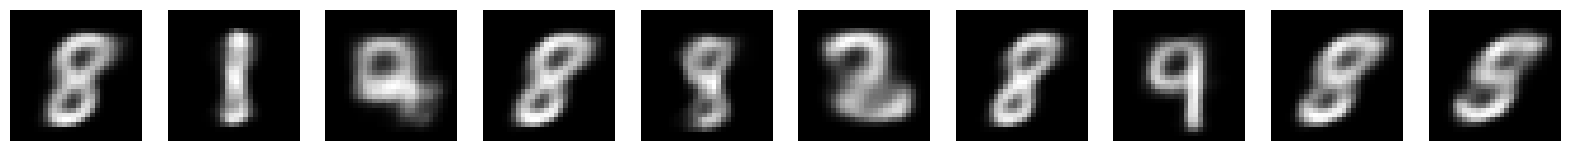

In [21]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(generated_images[i].reshape(28,28), cmap="gray")
    plt.axis("off")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


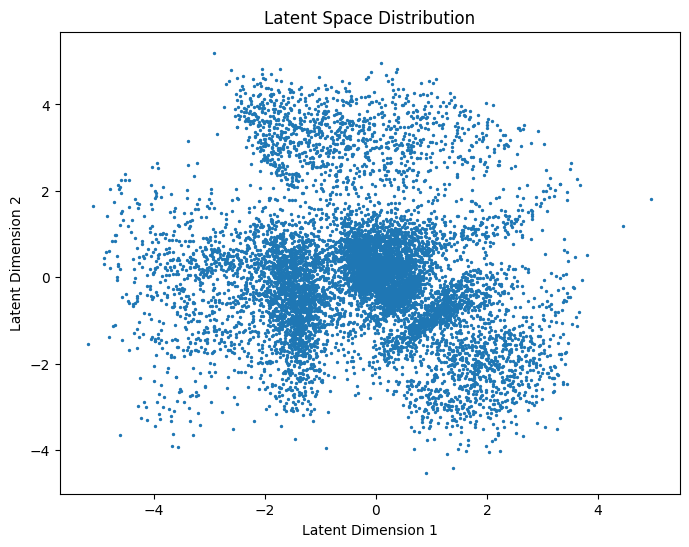

In [22]:
z_mean, _, _ = encoder.predict(x_test)

plt.figure(figsize=(8,6))
plt.scatter(z_mean[:,0], z_mean[:,1], s=2)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Distribution")
plt.show()
